# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



Link to the passed proposal: https://review.udacity.com/#!/reviews/4009788

##Problem Statement

That I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has two steps. First, I will combine customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will use the LinearRegression model. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "drive/MyDrive/Capstone project"

/content/drive/MyDrive/Capstone project


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score,  recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [ ]:
portfolio.shape

(10, 6)

In [ ]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [ ]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [ ]:
profile.shape

(17000, 5)

In [ ]:
profile.age.min(),profile.age.max()

(18, 118)

In [ ]:
profile.became_member_on.min(),profile.became_member_on.max()


(20130729, 20180726)

In [ ]:
profile.income.min(), profile.income.max()

(30000.0, 120000.0)

In [ ]:
for x in range(profile.shape[0]):
  if not ((profile.gender[x]=='F') | (profile.gender[x]=="M")):
    profile.gender[x]='O'

In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,O,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
transcript.shape

(306534, 4)

In [ ]:
transcript.time.min(), transcript.time.max()

(0, 714)

Preprocess Portfolio data

In [ ]:
df_portfolio=portfolio
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
channels_value=set()
for val in df_portfolio.channels:
  channels_value.update(set(val))

for val in channels_value:
      df_portfolio[val] = df_portfolio.channels.apply(lambda x: 1 if val in x else 0)

df_portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [ ]:
df_portfolio["sum"]=df_portfolio.email+df_portfolio.social+df_portfolio.mobile+df_portfolio.web

df_portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,web,social,sum
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,3
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,4
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0,2
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,4
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,3


<Axes: title={'center': 'offer Type'}, ylabel='id'>

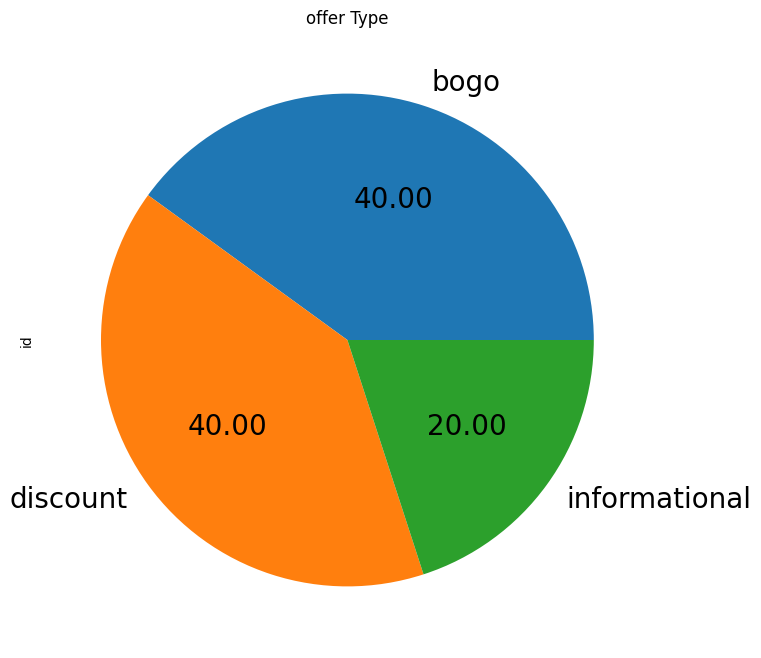

In [ ]:
df_portfolio.groupby('offer_type').id.count().plot.pie(figsize=(8, 8), fontsize = 20, autopct = '%.2f', title = 'offer Type')



Preprocess Profile data

In [98]:
df_profile=profile
df_profile

,gender,age,id,became_member_on,income,Date,year,month,days
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017,7,15
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017,5,9
4,O,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,2017,8,4
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07,2016,3,7


In [99]:
df_profile['Date'] = df_profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
df_profile['year'] = df_profile.became_member_on.astype(str).apply(lambda x: int((x)[:4]))
df_profile['month'] = df_profile.became_member_on.astype(str).apply(lambda x: int((x)[4:6]))
df_profile['days'] = df_profile.became_member_on.astype(str).apply(lambda x: int((x)[6:]))
df_profile.head()

,gender,age,id,became_member_on,income,Date,year,month,days
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017,7,15
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017,5,9
4,O,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,2017,8,4


In [100]:
df_profile.gender.value_counts()/len(df_profile)

M    0.499059
F    0.360529
O    0.140412
Name: gender, dtype: float64

Text(0.5, 1.0, 'Gender Distribution')

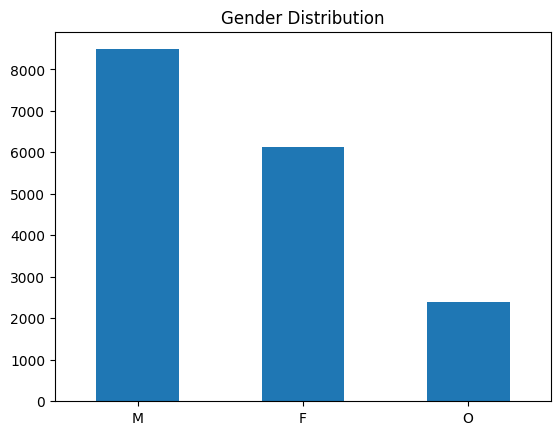

In [101]:
df_profile.gender.value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title("Gender Distribution")

In [102]:
df_profile=df_profile[(df_profile['gender'] == 'F') | (df_profile['gender'] == 'M')]
df_profile['gender'] = df_profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

df_profile

,gender,age,id,became_member_on,income,Date,year,month,days
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017,7,15
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017,5,9
5,1,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,2018,4,26
8,1,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09,2018,2,9
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017-11-11,2017,11,11
...,...,...,...,...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04,2018,6,4
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13,2018,7,13
16997,1,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26,2017,1,26
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07,2016,3,7


In [103]:
df_profile.gender.value_counts()/len(df_profile)

1    0.580579
0    0.419421
Name: gender, dtype: float64

I see that the proportion of males is higher than females

In [ ]:
df_profile = df_profile.sort_values(by=['Date'], ascending=False)
df_profile = df_profile.drop(labels='became_member_on', axis=1)
df_profile = df_profile.rename(columns={'Date': 'became_member_on'})


Preprocess Transcript data

In [ ]:
df_transcript =transcript
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


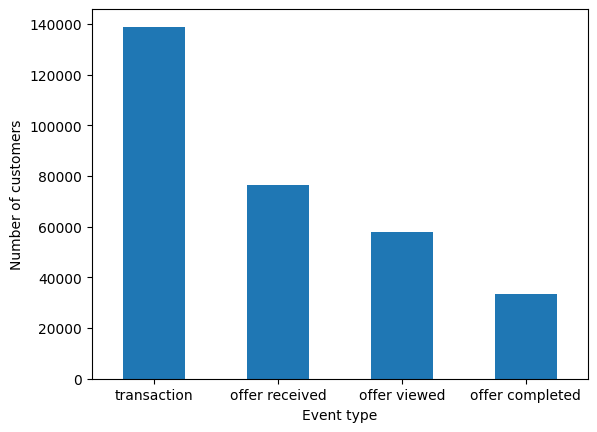

In [ ]:
df_transcript.event.value_counts().plot.bar()
plt.xlabel('Event type');
plt.ylabel('Number of customers');
plt.xticks(rotation=0); 

In [ ]:
df_transcript['value_keys'] = df_transcript.value.apply(lambda x: list(x.keys())[0]) 
df_transcript['values'] = df_transcript.value.apply(lambda x: list(x.values())[0]) 
df_transcript.head()

,person,event,value,time,value_keys,values
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [ ]:
def make_columns (df):
    
    
    """Create  columns for amount, reward and offer_id
    update offer_id columm
    update amount,reword column  
    Change time column from hours to days
  
    input : the transcript dataframe we want to add columns to
       
    Returns:clean dataframe
    
    """

    df.assign(amount='', reward='',offer_id='')
  
 
    for ndx, row in df.iterrows():
        for o in row['value']:
            if o == 'offer_id' or o == 'offer id':
                df.at[ndx, 'offer_id']= row['value'][o]
            if o == 'amount':
                df.at[ndx, 'amount']= row['value'][o]
            if o == 'reward':
                df.at[ndx, 'reward']= row['value'][o]

                  
   
    df['time'] = df['time']/24.
    

    
    return df

In [ ]:
df_transcript = make_columns(df_transcript)

In [ ]:

df_transcript = df_transcript.drop(labels='value', axis=1,)
df_transcript

,person,event,time,value_keys,values,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,offer id,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,offer id,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,amount,1.59,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,amount,9.53,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,amount,3.61,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,amount,3.53,NaN,3.53,NaN


In [ ]:
print(df_portfolio.shape)
print(df_profile.shape)
print(df_transcript.shape)

(10, 11)
(14613, 8)
(306534, 8)


In [ ]:
df_transcript = pd.get_dummies(df_transcript, columns=['event'], prefix = '', prefix_sep='')
df_transcript = df_transcript.groupby('person').sum().reset_index()


In [ ]:
print(df_transcript.shape)

(17000, 8)


In [ ]:
df_transcript.rename(columns={'person': 'user_id'}, inplace=True)
df_profile.rename(columns={'id': 'user_id'}, inplace=True)
df_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)


Merge the dataframes to make data for modeling

In [ ]:
merge_data = pd.merge(  df_transcript, df_profile,  on = 'user_id', how = 'right')
merge_data

,user_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,gender,age,income,became_member_on,year,month,days
0,e4989ca3d8974e28a3fe87aa0b0ce327,378.00,217.23,17.0,4,6,5,12,1,46,74000.0,2018-07-26,2018,7,26
1,3d50b3815c8e4f3b84f46be4d1b64cd3,190.75,7.78,0.0,0,6,4,2,1,59,34000.0,2018-07-26,2018,7,26
2,f1f01be4e2344bf08b7f488c115ad374,195.00,74.99,8.0,2,4,3,7,1,85,45000.0,2018-07-26,2018,7,26
3,6597e5ab63754726b83ba2032f008d26,313.50,87.53,27.0,5,5,4,4,1,76,92000.0,2018-07-26,2018,7,26
4,42f00b6b150e45149c50db9bd642bca6,181.75,37.59,10.0,1,5,3,2,0,45,70000.0,2018-07-26,2018,7,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14608,7b42b5bbe237406aaf2748a09050f745,168.50,57.64,5.0,1,4,3,5,0,67,58000.0,2013-07-31,2013,7,31
14609,5ffdab087e674149a89324a732b4f993,476.75,32.53,10.0,2,4,3,16,1,52,65000.0,2013-07-30,2013,7,30
14610,d25f38519a89455499c9e49e67ae1511,371.75,63.95,4.0,2,6,3,18,0,58,55000.0,2013-07-30,2013,7,30
14611,dbb4766b7dd94ca2b83a855312a3ebe9,166.00,37.12,3.0,1,2,1,8,1,36,74000.0,2013-07-30,2013,7,30


In [ ]:
model_data= merge_data[['time', 'offer completed', 'amount', 'reward','age' , 'gender' , 'income']]
model_data

,time,offer completed,amount,reward,age,gender,income
0,378.00,4,217.23,17.0,46,1,74000.0
1,190.75,0,7.78,0.0,59,1,34000.0
2,195.00,2,74.99,8.0,85,1,45000.0
3,313.50,5,87.53,27.0,76,1,92000.0
4,181.75,1,37.59,10.0,45,0,70000.0
...,...,...,...,...,...,...,...
14608,168.50,1,57.64,5.0,67,0,58000.0
14609,476.75,2,32.53,10.0,52,1,65000.0
14610,371.75,2,63.95,4.0,58,0,55000.0
14611,166.00,1,37.12,3.0,36,1,74000.0


Text(0.5, 1.0, 'Offers completion rate based on gender')

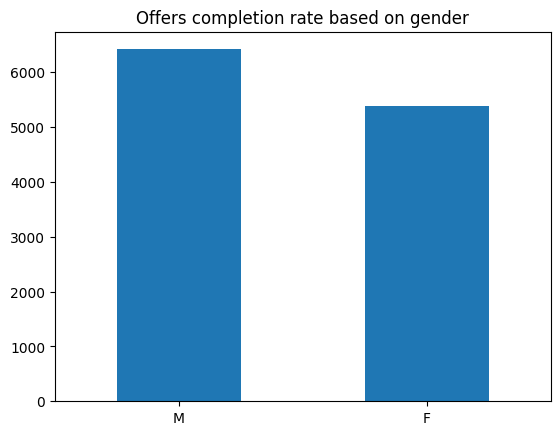

In [121]:
# plot the the offers acceptance rate based on gender 
model_data[model_data['offer completed']>=1].gender.value_counts().plot.bar()
plt.xticks(ticks=[1,0],labels=['F','M'],rotation=0)
plt.title("Offers completion rate based on gender")

In [140]:
model_data[model_data['offer completed']>=1].gender.value_counts()/len([i for i,x in enumerate(model_data['offer completed']>0) if x])


1    0.543406
0    0.456594
Name: gender, dtype: float64

We see that the proportion of men completed an offer to women completed an offer is nearly the same.

In [ ]:
X = model_data[['time', 'amount', 'reward', 'age', 'gender', 'income']]
y = model_data['offer completed']


#Modeling

I will try to build models using scikit-learn library. I will use Linear Regression, Logistic Regression, and Decision Tree Classifier.

First, Normalizing numeric data

In [ ]:
sc = MinMaxScaler()
norm = ['time', 'amount', 'reward', 'age', 'gender', 'income']

X[norm] = sc.fit_transform(X[norm])
X.head()

,time,amount,reward,age,gender,income
0,0.421814,0.135035,0.309091,0.337349,1.0,0.488889
1,0.196143,0.004836,0.000000,0.493976,1.0,0.044444
2,0.201265,0.046616,0.145455,0.807229,1.0,0.166667
3,0.344080,0.054411,0.490909,0.698795,1.0,0.688889
4,0.185297,0.023367,0.181818,0.325301,0.0,0.444444


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.4)
X_train.shape,X_test.shape

((8767, 6), (5846, 6))

###Linear Regression (as a benchmark model)

Linear Regression used as supervised machine learning algorithm to predict the number of accepted offers by customer.

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

R-squared is a common evaluation metric used in linear regression to measure the goodness of fit of the regression line to the data points. In this case, R-squared can be used to measure how well the linear regression model fits the data.

In [ ]:
pred_score = lr.predict(X_test)
r2_score(y_test, pred_score)

0.832872782096747

###Make the dataset suitable for classification.

Because the classification algorithms we will use works better with binary data we will need our data to be binary so I will change the "offer completed" column to binary representation.

In [ ]:
y_classification=y.apply(lambda x:1 if x>0 else 0)

In [ ]:
y_classification.value_counts()

1    11807
0     2806
Name: offer completed, dtype: int64

In [ ]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, random_state=42,test_size=0.4)
X_train.shape,X_test.shape

((8767, 6), (5846, 6))

###Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_class, y_train_class)


DecisionTreeClassifier()

accuracy is a commonly used evaluation metric for classification problems. It measures the proportion of correct predictions made by the model among all predictions. For logistic regression and decision tree classifier, accuracy is a suitable evaluation metric as the goal is to predict whether a given data point belongs to a certain class or not.

In [ ]:
pred_score = dtc.predict(X_test_class)
print('Accuracy {}'.format(accuracy_score(y_test_class, pred_score)))

Accuracy 1.0


###Logistic Regression model

In [ ]:
logr = LogisticRegression()
logr.fit(X_train_class, y_train_class)


LogisticRegression()

In [ ]:
pred_score = logr.predict(X_test_class)
print('Accuracy {}'.format(accuracy_score(y_test_class, pred_score)))

Accuracy 0.974512487170715


##Evaluation Metrics 
It is important to note that while R-squared is a suitable evaluation metric for linear regression, it is not appropriate for classification problems. Similarly, accuracy may not be an appropriate evaluation metric for all classification problems, it is crucial to choose appropriate evaluation metrics based on the characteristics of the problem and the goals of the analysis.






In [ ]:
# make a list with classification models
models = [dtc, logr ]
models_accuracy = [x1.score(X_train_class, y_train_class)*100 for x1 in models]
test_accuracy = [y1.score(X_test_class,y_test_class)*100 for y1 in models]
# add linear regression model
models_accuracy.append(lr.score(X_train,y_train)*100)
test_accuracy.append(lr.score(X_test,y_test)*100)
models.append(lr)
model_names = [type(n).__name__ for n in models]


In [ ]:
results = [models_accuracy,test_accuracy]
results_df = pd.DataFrame(results, columns = model_names,index=['Training Accuracy', 'Test Accuracy'])
results_df

,DecisionTreeClassifier,LogisticRegression,LinearRegression
Training Accuracy,100.0,97.547622,83.151423
Test Accuracy,100.0,97.451249,83.287278


###Results

From the accuracy scores we find that the Decision tree classifier has the best accuracy. It seems that the classification models work better with the dataset but it only show if the user will accept an offer or not, but won't show the number of offers accepted per user like Linear Regression model it depends on what do stakeholders need.

## Improvement 

I think with more data and different features in the dataset it would be much better results and gives me the chance to use more complicated algorithms. But for now I will use grid search to find the best parameters for Decision Tree Classifier.

In [ ]:
Dectree = DecisionTreeClassifier()

pm =  {'min_samples_split' : range(20,400,30),'max_depth': range(1,20,2)}

gs= GridSearchCV(Dectree, pm)
gfit = gs.fit(X_train_class, y_train_class)

bclf = gfit.best_estimator_


pred = (Dectree.fit(X_train_class, y_train_class)).predict(X_test)
bpred = bclf.predict(X_test_class)


In [ ]:
print("Accuracy score: {:.4f}".format(accuracy_score(y_test_class, pred)))
print("Final accuracy score: {:.4f}".format(accuracy_score(y_test_class, bpred)))
print(f'Best params: {gfit.best_params_}')

Accuracy score: 1.0000
Final accuracy score: 1.0000
Best params: {'max_depth': 1, 'min_samples_split': 20}


It won't make much difference because the model achieves the full accuracy. But now we know what is the best parameters to use with Decision Tree Classifier


##Conclusion

The goal of this project is to predict how the customer will interact with the offers that Starbuck will present. Firstly, I took the provided data that requires some cleaning activity, then I did the needed changes to analyze that data that required to be applied before starting the data exploring activity. Finally, I used three models first LinearRegression model I got nearly 84%, Second, DecisionTreeClassifier I got 100%, third, LogisticRegression I got 97% accuracy. It seems that the classification models work better with the dataset but it only shows if the user will accept an offer or not but won't show the number of offers accepted per user it depends on what do stakeholders need. Moreover, Starbuck can use these models to enhance their offers periodically after each offer to know the real benefits to aim their offer to the correct audience